In [2]:
import torch
import json
import argparse
import numpy as np
from train_procedure import train_with_LBFGS
from lbm_nmar import LBM_NMAR
from lbfgs import FullBatchLBFGS
from utils import reparametrized_expanded_params, init_random_params
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
##############" LOADING Arguments" ################

nq = 3 #enter nb of row classes
nl = 5 #enter nb of col classes
device = 'cuda' #put 'cuda' or 'cpu'
device2 = None #put None or 'cuda'

if not torch.cuda.is_available() and device != 'cpu':
    print('Cuda is not available. Algorithm will use cpu')
    device, device2 = torch.device('cpu'), None

Cuda is not available. Algorithm will use cpu


In [4]:
##############" LOADING DATASET" ################

votes = np.loadtxt("data_parliament/votes.txt",delimiter=";").astype(int)

deputes = json.load(open('data_parliament/deputes.json', 'r')) 
#deputes: Dataset with: Family name, Name, Political group 
texts = json.load(open('data_parliament/texts.json', 'r'))
#texts: Dataset with: political group demanding, title of demand, date, type (type of vote, type of majority, name of type of vote), 
n1, n2 = votes.shape 
# shape of dataset: 
# n1= row length , n2 = col length
print(n1,n2)

576 1256


In [5]:
##############" Init and creating model " ################
vector_of_parameters = torch.tensor(init_random_params(n1, n2, nq, nl), requires_grad=True, device=device)

In [6]:
model = LBM_NMAR(
    vector_of_parameters,
    votes,
    (n1, n2, nq, nl),
    device=device,
    device2=device2,
)

try:
    success, loglike = train_with_LBFGS(model)
except KeyboardInterrupt:
    print("KeyboardInterrupt detected, stopping training")

# Parameters of the model
(
    nu_a,
    rho_a,
    nu_b,
    rho_b,
    nu_p,
    rho_p,
    nu_q,
    rho_q,
    tau_1,
    tau_2,
    mu_un,
    sigma_sq_a,
    sigma_sq_b,
    sigma_sq_p,
    sigma_sq_q,
    alpha_1,
    alpha_2,
    pi,
) = reparametrized_expanded_params(torch.cat((model.variationnal_params, model.model_params)), n1, n2, nq, nl, device)

-------------------------------------------------------------------------------- 
Start training LBM MNAR 
 --------------------------------------------------------------------------------
Number of row classes :  3
Number of col classes :  5
 EM step  |   LBFGS iter  | criteria |


/Users/laurafuentesvicente/M2 Maths&IA/Methodes Non Supervises avancees/Projet/LBM-MNAR/lbfgs.py:339: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1699448805816/work/torch/csrc/utils/python_arg_parser.cpp:1519.)
  p.data.add_(


 0  |   1  | 338861.97729 |
 0  |   2  | 327134.77311 |
 0  |   3  | 320251.32903 |
 0  |   4  | 316517.06737 |
 0  |   5  | 315484.13194 |
 0  |   6  | 314564.81952 |
 0  |   7  | 314113.13016 |
 0  |   8  | 313814.33743 |
 0  |   9  | 313586.70747 |
 0  |   10  | 313339.41411 |
 0  |   11  | 313051.52097 |
 0  |   12  | 312735.04658 |
 0  |   13  | 312248.91458 |
 0  |   14  | 311935.06388 |
 0  |   15  | 311454.21942 |
 0  |   16  | 311027.08037 |
 0  |   17  | 310226.09162 |
 0  |   18  | 309743.86602 |
 0  |   19  | 308954.86616 |
 0  |   20  | 307963.40350 |
 0  |   21  | 307955.75626 |
 0  |   22  | 307955.52139 |
 0  |   23  | 307955.47935 |
 0  |   24  | 307955.45225 |
 0  |   25  | 307955.44367 |
 0  |   26  | 307955.43899 |
 0  |   27  | 307955.43776 |
 0  |   28  | 307955.43706 |
 0  |   29  | 307955.43668 |
 0  |   30  | 307955.43665 |
------------------------------  Optimizing next EM step  ------------------------------
 EM step  |   LBFGS iter  | criteria |
 1  |   1  |

In [8]:
# Get the row and column classes with the MAP on the varitional distributions
tau_1 = np.array(tau_1.tolist())
tau_2 = np.array(tau_2.tolist())
row_classes = tau_1.argmax(axis=1)
column_classes = tau_2.argmax(axis=1)
print("Texts classes : ", column_classes)
print("MPs classes : ", row_classes)
print([[(deputes[i]['nom'], deputes[i]['groupe']) for i, c in enumerate(row_classes) if c == nq] for nq in range(nq)])

Texts classes :  [0 3 3 ... 1 1 4]
MPs classes :  [0 0 1 2 1 0 2 0 0 2 0 0 2 0 0 0 0 0 0 1 0 0 1 1 2 0 2 0 1 0 0 0 2 2 0 2 1
 2 1 1 0 2 0 0 2 0 1 1 0 0 1 1 1 2 1 0 0 2 0 2 0 0 2 1 2 0 0 0 2 0 1 0 0 0
 2 2 0 2 1 0 0 2 0 2 2 2 2 0 1 2 2 0 1 2 0 0 1 0 2 2 0 1 2 0 2 0 1 1 0 0 0
 1 1 0 0 0 0 0 1 1 2 0 2 2 1 0 1 0 2 1 0 0 1 0 2 0 0 0 2 0 1 0 1 0 2 2 1 2
 0 0 0 0 2 1 0 2 2 0 0 1 0 1 2 1 2 0 0 1 2 2 0 1 1 1 1 0 0 0 0 1 0 0 0 1 1
 1 2 0 0 1 2 1 2 0 1 1 0 0 1 1 0 0 0 2 1 2 1 0 1 0 2 1 0 1 0 0 1 0 1 0 2 1
 1 1 2 1 2 0 2 0 2 2 0 0 1 0 0 0 0 0 0 1 1 1 0 2 0 0 0 1 0 2 0 1 0 1 0 0 0
 0 0 2 1 0 1 2 2 2 1 2 0 0 0 1 2 2 0 0 2 0 0 0 0 0 2 2 2 2 1 0 0 2 2 1 1 0
 2 1 1 1 1 0 0 0 2 2 2 2 1 0 0 2 1 2 1 0 1 1 2 1 0 0 2 0 1 1 0 0 2 2 0 0 0
 2 0 0 0 2 0 0 2 0 0 0 2 1 2 1 0 0 0 2 1 2 0 0 2 0 2 2 2 2 0 1 0 0 0 0 0 0
 0 0 1 0 2 2 2 0 1 2 0 2 2 0 0 0 0 0 1 0 1 1 0 2 0 0 0 2 1 2 0 0 0 0 2 1 2
 2 0 0 2 1 0 0 2 2 1 0 1 1 0 0 1 0 2 0 1 2 2 0 1 0 0 2 1 0 2 2 2 0 1 0 2 0
 0 0 1 0 1 2 1 0 1 2 2 0 1 0 0 1 0 1 2 0 0 1 1 0 1

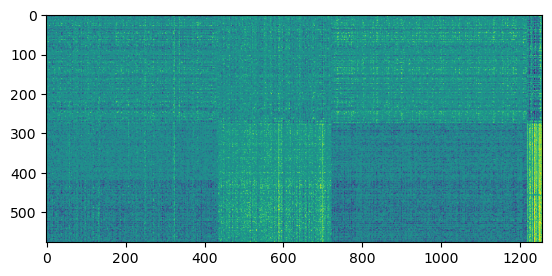

In [9]:
######### Display the vote matrix, rows and columns re-ordered according to their respective classes.
plt.imshow(
    votes[np.argsort(tau_1.argmax(axis=1)), :][
        :, np.argsort(tau_2.argmax(axis=1))
    ]
)
plt.show()
